### This is a script to to load the property dataset and run **AutoGluon** on it. First basic model run, then different configurations are tried. Then look at possible **third level ensembling** of the models.

In [ ]:
### installments

!pip install autogluon
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz
!pip install tabpfn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.0/428.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jamm

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor

ModuleNotFoundError: No module named 'autogluon'

In [3]:
random_seed = 42

In [6]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/361092'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
## Function for loading one of the 10 folds of the property dataset and concatinating the X and y values for train and test respectively.
import pandas as pd

def load_fold(fold_number, random_seed=42, sample_size=None):
    df_X_train = pd.read_parquet(f'{base_path}/{fold_number}/X_train.parquet')
    df_y_train = pd.read_parquet(f'{base_path}/{fold_number}/y_train.parquet')
    df_X_test = pd.read_parquet(f'{base_path}/{fold_number}/X_test.parquet')
    df_y_test = pd.read_parquet(f'{base_path}/{fold_number}/y_test.parquet')

    # concatinating the X and y values for train and test respectively
    df_train = pd.concat([df_X_train, df_y_train], axis=1)
    df_test = pd.concat([df_X_test, df_y_test], axis=1)

    # Convert to AutoGluon's TabularDataset
    if sample_size:
        train_dataset = TabularDataset(df_train).sample(n=sample_size, random_state=random_seed)
        test_dataset = TabularDataset(df_test).sample(n=sample_size, random_state=random_seed)
    else:
        train_dataset = TabularDataset(df_train)
        test_dataset = TabularDataset(df_test)

    return train_dataset, test_dataset

# Also instantiate the target column
label_property = 'oz252'


In [8]:
## Function to fit the model, with most of the hyperparameters present and set to default/None. (Add more hyperparameters if desirable)

from autogluon.tabular import TabularPredictor

def fit_gluon(train_dataset, problem_type='regression', hyperparameters=None, eval_metric='r2', presets='medium_quality', time_limit=100, auto_stack=None, num_bag_folds=None, num_bag_sets=None, num_stack_levels=None, num_trials=None, verbosity=None, ag_args_fit=None, feature_prune=None, excluded_model_types=None):
    predictor = TabularPredictor(label=label_property, problem_type=problem_type, eval_metric=eval_metric)

    fit_args = {
        'train_data': train_dataset,
        'presets': presets,
        'time_limit': time_limit,
    }

    if hyperparameters is not None:
        fit_args['hyperparameters'] = hyperparameters
    if auto_stack is not None:
        fit_args['auto_stack'] = auto_stack
    if num_bag_folds is not None:
        fit_args['num_bag_folds'] = num_bag_folds
    if num_bag_sets is not None:
        fit_args['num_bag_sets'] = num_bag_sets
    if num_stack_levels is not None:
        fit_args['num_stack_levels'] = num_stack_levels
    if num_trials is not None:
        fit_args['num_trials'] = num_trials
    if verbosity is not None:
        fit_args['verbosity'] = verbosity
    if ag_args_fit is not None:
        fit_args['ag_args_fit'] = ag_args_fit
    if feature_prune is not None:
        fit_args['feature_prune'] = feature_prune
    if excluded_model_types is not None:
        fit_args['excluded_model_types'] = excluded_model_types

    predictor.fit(**fit_args)
    return predictor



In [9]:
## Function to evaluate a fitted model and training set.

def evaluate_gluon(model, test_dataset):
    test_score = model.evaluate(test_dataset)
    leaderboard = model.leaderboard(test_dataset)
    return test_score, leaderboard

In [11]:
## First training the model speratly on all 10 folds to see that it is consistent

for fold_number in range(1, 2): # jsut the first to start with
    train_dataset, test_dataset = load_fold(fold_number, random_seed=random_seed)
    model = fit_gluon(train_dataset, time_limit=2000, presets='high_quality')
    test_score, leaderboard = evaluate_gluon(model, test_dataset)
    print(f'Fold {fold_number}\n\n: {test_score} \n\n')
    print(leaderboard)


No path specified. Models will be saved in: "AutogluonModels/ag-20240702_082123"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024
CPU Count:          2
Memory Avail:       11.16 GB / 12.67 GB (88.0%)
Disk Space Avail:   46.70 GB / 78.19 GB (59.7%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enab

Fold 

 1: {'r2': 0.07766114711953387, 'root_mean_squared_error': -0.025582537197990585, 'mean_squared_error': -0.000654466209486572, 'mean_absolute_error': -0.01846112297459743, 'pearsonr': 0.29126989693397143, 'median_absolute_error': -0.013395467689514162} 


                               model  score_test  score_val eval_metric  \
0          CatBoost_r177_BAG_L1_FULL    0.084717        NaN          r2   
1          LightGBM_r131_BAG_L1_FULL    0.084520        NaN          r2   
2           WeightedEnsemble_L2_FULL    0.077661        NaN          r2   
3            CatBoost_r9_BAG_L1_FULL    0.077225        NaN          r2   
4             LightGBMXT_BAG_L1_FULL    0.076856        NaN          r2   
5               LightGBM_BAG_L1_FULL    0.076227        NaN          r2   
6            XGBoost_r33_BAG_L1_FULL    0.073999        NaN          r2   
7           LightGBM_r96_BAG_L1_FULL    0.073765        NaN          r2   
8               CatBoost_BAG_L1_FULL    0.071711        NaN   

No path specified. Models will be saved in: "AutogluonModels/ag-20240702_085627"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024
CPU Count:          2
Memory Avail:       10.12 GB / 12.67 GB (79.9%)
Disk Space Avail:   45.85 GB / 78.19 GB (58.6%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enab

KeyboardInterrupt: 

In [23]:
model.feature_importance(test_dataset)

These features in provided data are not utilized by the predictor and will be ignored: ['oz50', 'oz69', 'oz100', 'oz107', 'oz111', 'oz115']
Computing feature importance via permutation shuffling for 56 features using 888 rows with 5 shuffle sets...
	372.15s	= Expected runtime (74.43s per shuffle set)
	44.29s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
oz251,0.215600,0.014740,2.605287e-06,5,0.245950,0.185251
oz249,0.151272,0.006864,5.072224e-07,5,0.165405,0.137140
oz151,0.117863,0.006892,1.396675e-06,5,0.132054,0.103672
oz246,0.102660,0.002641,5.251960e-08,5,0.108098,0.097222
oz247,0.096256,0.006216,2.075437e-06,5,0.109055,0.083457
oz13,0.084232,0.004374,8.690227e-07,5,0.093238,0.075227
oz250,0.081146,0.004392,1.026169e-06,5,0.090190,0.072102
oz248,0.069838,0.001882,6.316304e-08,5,0.073712,0.065963
oz175,0.069092,0.003302,6.237928e-07,5,0.075890,0.062294
oz150,0.061265,0.004218,2.680104e-06,5,0.069951,0.052579


In [15]:
for fold_number in range(1, 2): # jsut the three first to start with
    train_dataset, test_dataset = load_fold(fold_number, random_seed=random_seed)
    model = fit_gluon(train_dataset, time_limit=100)
    test_score, leaderboard = evaluate_gluon(model, test_dataset)
    print(f'Fold {fold_number}: {test_score}')
    print(leaderboard)


No path specified. Models will be saved in: "AutogluonModels/ag-20240702_093443"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024
CPU Count:          2
Memory Avail:       9.92 GB / 12.67 GB (78.3%)
Disk Space Avail:   45.84 GB / 78.19 GB (58.6%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20240702_093443"
Train Data Rows:    7996
Train Data Columns: 62
Label Column:       oz252
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10163.55 MB
	Train Data (Original)  Memory Usage: 2.72 MB (0.0% of available memory)
	Inferring data type of each feature b

Fold 1: {'r2': 0.08900780402347996, 'root_mean_squared_error': -0.025424691438009624, 'mean_squared_error': -0.0006464149347179998, 'mean_absolute_error': -0.018338991526840775, 'pearsonr': 0.3020016838586487, 'median_absolute_error': -0.013147535247802766}
                  model  score_test  score_val eval_metric  pred_time_test  \
0   WeightedEnsemble_L2    0.089008   0.110349          r2        0.655178   
1              CatBoost    0.089001   0.089654          r2        0.009564   
2         LightGBMLarge    0.079066   0.087833          r2        0.011603   
3               XGBoost    0.077817   0.065368          r2        0.016926   
4            LightGBMXT    0.077281   0.087110          r2        0.021298   
5              LightGBM    0.072527   0.078010          r2        0.008025   
6         ExtraTreesMSE    0.062203   0.086513          r2        0.251512   
7       RandomForestMSE    0.048234   0.078561          r2        0.310097   
8       NeuralNetFastAI    0.008027   0.

In [18]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=168498 sha256=dda629724aacb2340be2d172bed30f0fa20acbb6c272f994ae749cd762ed08ea
  Stored in directory: /root/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


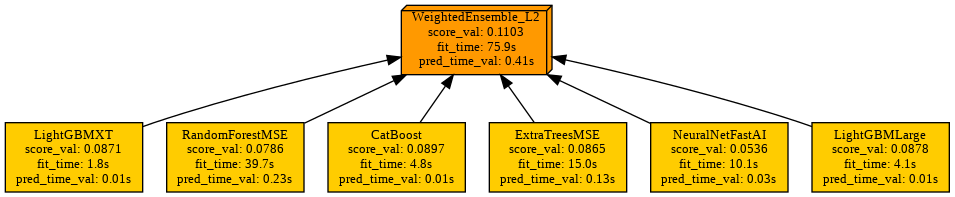

In [20]:
path_to_png = model.plot_ensemble_model()
from IPython.display import Image, display
display(Image(filename=path_to_png))

In [3]:
## Making sets of all 10 folds

full_train = None
full_test = None

for fold_number in range(1, 11):
    train_dataset, test_dataset = load_fold(fold_number, random_seed=random_seed)
    if full_train is None:
        full_train = train_dataset
        full_test = test_dataset
    else:
        # Use pd.concat to combine TabularDatasets
        full_train = pd.concat([full_train, train_dataset])
        full_test = pd.concat([full_test, test_dataset])

NameError: name 'load_fold' is not defined

In [26]:
## Training the model on all 10 folds

model = fit_gluon(full_train, time_limit=100)
test_score, leaderboard = evaluate_gluon(model, full_test)
print(f'Full Train: {test_score}')
display(Image(filename=model.plot_ensemble_model()))

No path specified. Models will be saved in: "AutogluonModels/ag-20240702_102619"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024
CPU Count:          2
Memory Avail:       10.06 GB / 12.67 GB (79.4%)
Disk Space Avail:   45.45 GB / 78.19 GB (58.1%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20240702_102619"
Train Data Rows:    79965
Train Data Columns: 62
Label Column:       oz252
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10330.72 MB
	Train Data (Original)  Memory Usage: 27.15 MB (0.3% of available memory)
	Inferring data type of each featur

[1000]	valid_set's l2: 0.000349576	valid_set's r2: 0.560283
[2000]	valid_set's l2: 0.000223508	valid_set's r2: 0.718859
[3000]	valid_set's l2: 0.00014857	valid_set's r2: 0.81312
[4000]	valid_set's l2: 0.000104798	valid_set's r2: 0.868179
[5000]	valid_set's l2: 7.54596e-05	valid_set's r2: 0.905082
[6000]	valid_set's l2: 5.56457e-05	valid_set's r2: 0.930006
[7000]	valid_set's l2: 4.17541e-05	valid_set's r2: 0.947479
[8000]	valid_set's l2: 3.21521e-05	valid_set's r2: 0.959557


	Ran out of time, early stopping on iteration 8280. Best iteration is:
	[8280]	valid_set's l2: 2.9896e-05	valid_set's r2: 0.962395
	0.9624	 = Validation score   (r2)
	97.06s	 = Training   runtime
	1.33s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 98.34s of the -3.91s of remaining time.
	Ensemble Weights: {'KNeighborsUnif': 1.0}
	0.9947	 = Validation score   (r2)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 104.04s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 2053.2 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240702_102619")


Full Train: {'r2': 0.9903062537074445, 'root_mean_squared_error': -0.0029292002708376065, 'mean_squared_error': -8.580214226675108e-06, 'mean_absolute_error': -0.0002855074196261087, 'pearsonr': 0.9951420695870777, 'median_absolute_error': -1.546478267666629e-08}


In [2]:
## Training the model again without the least important columns

columns_to_drop = ['oz173', 'oz1', 'oz4', 'oz181', 'oz11', 'oz31', 'oz178', 'oz83', 'oz87', 'oz234', 'oz96', 'oz135', 'oz206', 'oz40', 'oz73', 'oz42', 'oz112', 'oz113', 'oz71', 'oz222', 'oz108', 'oz46' ]

full_train_drop = full_train.drop(columns=columns_to_drop)
full_test_drop = full_test.drop(columns=columns_to_drop)

model = fit_gluon(full_train_drop, time_limit=100)
test_score, leaderboard = evaluate_gluon(model, full_test_drop)
print(f'Full Train: {test_score}')
display(Image(filename=model.plot_ensemble_model()))


NameError: name 'full_train' is not defined

In [25]:
## Testing to see if TabPFN works well

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier



In [ ]:
## Creating an ensemble of the 10 models??